In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths to dataset
train_path = "F:/emotion_detector/archive (1)/train"
test_path = "F:/emotion_detector/archive (1)/test"

# Create data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from folders
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(48, 48),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(48, 48),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical'
)


# ✅ Step 1: Build the CNN Model
model = Sequential()

# Conv Block 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Conv Block 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Conv Block 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))  # 7 emotions

# ✅ Step 2: Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Step 3: Train the Model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=25,
    verbose=1
)

# ✅ Step 4: Save the Model
model.save("emotion_model.h5")


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


c:\Users\rishi\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 447s 495ms/step - accuracy: 0.2494 - loss: 2.1125 - val_accuracy: 0.3782 - val_loss: 1.5918
Epoch 2/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 79s 88ms/step - accuracy: 0.3721 - loss: 1.6192 - val_accuracy: 0.4280 - val_loss: 1.4877
Epoch 3/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 80s 89ms/step - accuracy: 0.4149 - loss: 1.5051 - val_accuracy: 0.4563 - val_loss: 1.4166
Epoch 4/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 82s 88ms/step - accuracy: 0.4497 - loss: 1.4227 - val_accuracy: 0.4613 - val_loss: 1.3883
Epoch 5/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 80s 89ms/step - accuracy: 0.4741 - loss: 1.3666 - val_accuracy: 0.4889 - val_loss: 1.3250
Epoch 6/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 87s 96ms/step - accuracy: 0.5081 - loss: 1.2865 - val_accuracy: 0.5018 - val_loss: 1.2953
Epoch 7/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 144s 99ms/step - accuracy: 0.5297 - loss: 1.2329 - val_accuracy: 0.5071 - val_loss: 1.2765
Epoch 8/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 82s 91ms/step - accuracy: 0.5512 - loss: 1.1749

EVALUATE THE MODEL

In [3]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.5596 - loss: 1.4268
Test Accuracy: 55.92%


Visualize Training Progress (Optional)
Plot accuracy/loss graphs:

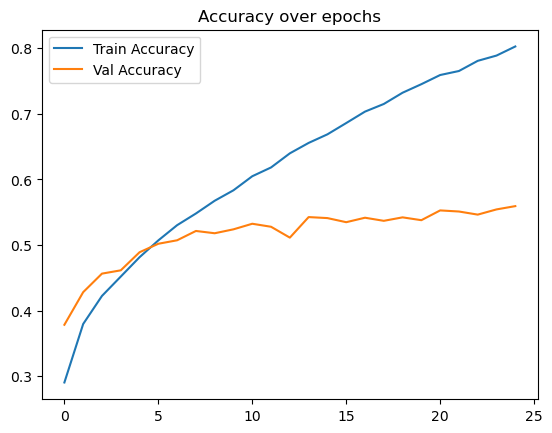

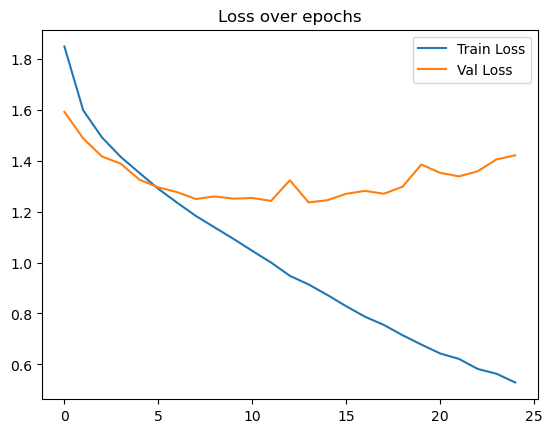

In [4]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()


Use the Model for Real-Time Emotion Detection.
Build a real-time inference script using OpenCV.

In [5]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np

# Load model and class labels
model = load_model("emotion_model.h5")
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Load face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    grayscale = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(grayscale, 1.3, 5)

    for (x, y, w, h) in faces:
        roi = grayscale[y:y+h, x:x+w]
        roi = cv2.resize(roi, (48, 48))
        roi = roi.astype('float32') / 255.0
        roi = np.expand_dims(roi, axis=0)
        roi = np.expand_dims(roi, axis=-1)

        prediction = model.predict(roi)
        emotion = emotion_labels[np.argmax(prediction)]

        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

    cv2.imshow("Real-Time Emotion Detection", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
